# Playground with pytorch

## Imports

In [15]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from torchvision.models import resnet18, ResNet18_Weights

## Autograd

In [3]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)

data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

In [4]:
prediction = model(data)

In [5]:
loss = (prediction - labels).sum()
loss.backward()

In [6]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=.9)

In [7]:
optim.step()

### Differentiation in Autograd

In [8]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

In [9]:
Q = 3 * a ** 3 - b ** 2

In [10]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

In [11]:
print(9 * a ** 2 == a.grad)
print(-2 * b == b.grad)

tensor([True, True])
tensor([True, True])


## Neural Networks

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [13]:
net = Net()

In [14]:
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [15]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


In [16]:
_in = torch.randn(1, 1, 32, 32)
out = net(_in) 
print(out)

tensor([[-0.1328, -0.0451,  0.0971, -0.0724,  0.0831,  0.0892,  0.0266, -0.1949,
         -0.0203,  0.1645]], grad_fn=<AddmmBackward0>)


In [17]:
net.zero_grad()
out.backward(torch.randn(1, 10))

### Loss function

In [18]:
output = net(_in)
target = torch.randn(10)
target = target.view(1, -1)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.9936, grad_fn=<MseLossBackward0>)


In [19]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [20]:
net.zero_grad()

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-0.0147,  0.0063,  0.0133,  0.0110,  0.0037,  0.0120])


### Update weights

In [21]:
learning_rate = .01

for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [22]:
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)

optimizer.zero_grad()
output = net(_in)
loss = criterion(output, target)
loss.backward()
optimizer.step()

## Training a classifier

In [16]:
transfrom = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ]
)

batch_size = 4
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transfrom)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transfrom)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True, num_workers=2)

classes = 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'


Files already downloaded and verified
Files already downloaded and verified


In [17]:
def imshow(img) -> None:
    img = img / 2 + .5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [18]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

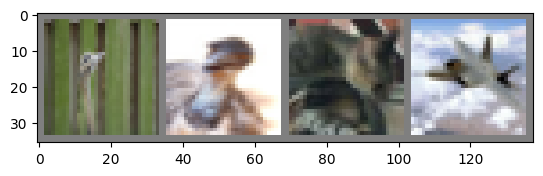

bird  bird  cat   plane


In [20]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Convolutional neural network

In [21]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [22]:
net = Net()

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=.001, momentum=.9)

Train the model

In [24]:
for epoch in range(2):
    running_loss = .0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

[1,  2000] loss: 2.192
[1,  4000] loss: 1.835
[1,  6000] loss: 1.657
[1,  8000] loss: 1.552
[1, 10000] loss: 1.504
[1, 12000] loss: 1.457
[2,  2000] loss: 1.414
[2,  4000] loss: 1.371
[2,  6000] loss: 1.343
[2,  8000] loss: 1.313
[2, 10000] loss: 1.323
[2, 12000] loss: 1.312


In [25]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Test the model

In [26]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

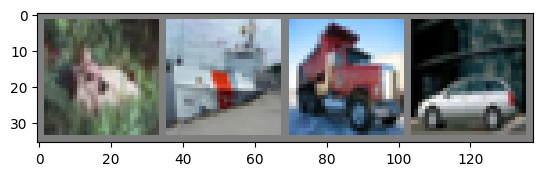

GroundTruth:  deer  ship  truck car  


In [27]:
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [28]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [29]:
outputs = net(images)

In [30]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  frog  ship  truck ship 


In [31]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [32]:
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


In [33]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

In [35]:
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 49.2 %
Accuracy for class: car   is 66.8 %
Accuracy for class: bird  is 39.0 %
Accuracy for class: cat   is 32.6 %
Accuracy for class: deer  is 39.3 %
Accuracy for class: dog   is 40.3 %
Accuracy for class: frog  is 72.1 %
Accuracy for class: horse is 52.9 %
Accuracy for class: ship  is 81.2 %
Accuracy for class: truck is 63.5 %


Train on gpu

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
net.to(device=device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [39]:
inputs, labels = data[0].to(device), data[1].to(device)